# Training & Inference Playground

This notebook orchestrates the existing CLI scripts for `LocationCNN`. Follow the cells below to train the model, persist metrics, visualize the curves, and run inference without leaving this workspace.

### Prerequisites

- Activate the repository environment (see `requirements/location_cnn.txt`).
- The MATLAB datasets live under `dataset/` (for example `dataset_SNR50_outdoor.mat`).
- Running the commands below writes artifacts under `checkpoints/`, `logs/`, `plots/`, and `artifacts/`.
- Each cell assumes `torch`, `matplotlib`, `numpy`, `pandas`, and `scikit-learn` are installed.

In [1]:
import sys
import os
import importlib
from pathlib import Path

# Ensure we are in the project root
if Path.cwd().name == "notebooks":
    os.chdir("..")
print(f"Current working directory: {Path.cwd()}")

# Add project root to sys.path to allow imports
if str(Path.cwd()) not in sys.path:
    sys.path.append(str(Path.cwd()))

print("Python", sys.version.split()[0])
for pkg in ["torch", "matplotlib", "numpy", "pandas", "sklearn"]:
    try:
        module = importlib.import_module(pkg)
        version = getattr(module, "__version__", "<builtin>")
        print(f"{pkg}: {version}")
    except Exception as exc:
        print(f"{pkg}: not installed ({exc})")

Current working directory: /Users/rbkv2/src/csi_positioning
Python 3.12.12
torch: 2.3.1
matplotlib: 3.10.7
numpy: 1.26.4
pandas: 2.3.3
sklearn: 1.5.0


## Model Architecture

The following cells display the LocationCNN architecture, including layer details, parameter counts, and a visual diagram of the network structure.

In [12]:
import torch
import numpy as np
from pathlib import Path
from location_cnn.models import LocationCNN
from location_cnn.data import load_mat_dataset

# --- Architecture Selection ---
ARCHITECTURE = "optimized"  # Options: "optimized", "original"
DATASET_PATH = "dataset/dataset_SNR50_outdoor.mat"

# Try to determine input shape from dataset, or calculate compatible shape
try:
    if Path(DATASET_PATH).exists():
        features, _ = load_mat_dataset(Path(DATASET_PATH))
        input_shape = features[0].shape
        print(f"Detected input shape from dataset: {input_shape}")
    else:
        # Default shape compatible with both architectures
        input_shape = (4, 16, 192)
        print(f"Dataset not found, using default input shape: {input_shape}")
except Exception as e:
    input_shape = (4, 16, 192)
    print(f"Could not load dataset, using default input shape: {input_shape}")
    print(f"Error: {e}")

# Instantiate model
print(f"\nInitializing '{ARCHITECTURE}' model architecture...")
model = LocationCNN(in_channels=input_shape[0], num_outputs=3, architecture=ARCHITECTURE)
model.eval()

# Print model architecture
print("\n" + "="*80)
print("MODEL ARCHITECTURE SUMMARY")
print("="*80)
print(model)
print("\n" + "="*80)

# Try to use torchinfo for detailed summary
try:
    try:
        from torchinfo import summary
        print("\nDETAILED ARCHITECTURE SUMMARY (torchinfo)")
        print("="*80)
        summary(
            model,
            input_size=(1, *input_shape),
            col_names=["input_size", "output_size", "num_params", "kernel_size", "stride", "padding"],
            verbose=1
        )
    except ImportError:
        try:
            from torchsummary import summary
            print("\nDETAILED ARCHITECTURE SUMMARY (torchsummary)")
            print("="*80)
            summary(model, input_shape)
        except ImportError:
            print("\nNote: Install 'torchinfo' or 'torchsummary' for detailed layer information")
            print("      Run: pip install torchinfo")
except Exception as e:
    print(f"\nCould not generate detailed summary: {e}")

# Calculate and print parameter statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_mb = total_params * 4 / (1024 * 1024)  # Assuming float32 (4 bytes)

print("\n" + "="*80)
print("MODEL STATISTICS")
print("="*80)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size (float32): {model_size_mb:.2f} MB")
print("="*80)

Detected input shape from dataset: (4, 16, 193)

Initializing 'optimized' model architecture...

MODEL ARCHITECTURE SUMMARY
LocationCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (regressor): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=768, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)


Note: Install 'torchinfo' or 'torchsummary' for detailed layer information
      Run: pip install torchinfo

MODEL STATISTICS
Total parameters: 122,547
Trainable parameters: 122,547
Model size (float32): 0.47 MB


In [4]:
# --- Configuration ---
DATASET_FILE = "dataset/dataset_SNR50_outdoor.mat"
EPOCHS = 50
BATCH_SIZE = 64
DEVICE = "cpu"
RETRAIN = True
SEED = 42

# Paths
METRICS_PATH = "logs/location_training_metrics_optimized.csv"
CHECKPOINT_PATH = "checkpoints/location_cnn_optimized.pt"
STATS_PATH = "artifacts/feature_stats_optimized.json"
QUANTIZED_MODULE_PATH = "artifacts/location_quantized_optimized.json"
INFERENCE_RESULTS_PATH = "artifacts/inference_results_optimized.csv"
PLOTS_DIR = "plots"

# Inference Settings
NUM_INFERENCE_SAMPLES = 10
FHE_MODE = "disable"  # Options: "disable", "simulate", "execute"

## Training the Location CNN

The `train_location_cnn.py` script normalizes the CSI dataset, trains the compact CNN, saves the checkpoint, and logs the metrics. You can override the dataset path via `--dataset-file`.

In [5]:
import sys
from pathlib import Path
from subprocess import run

print(f"Training with dataset: {DATASET_FILE}")

train_cmd = [
    sys.executable,
    "train_location_cnn.py",
    "--dataset-file", str(Path(DATASET_FILE)),
    "--epochs", str(EPOCHS),
    "--batch-size", str(BATCH_SIZE),
    "--device", DEVICE,
    "--metrics-dir", str(Path(METRICS_PATH).parent),
    "--checkpoint-dir", str(Path(CHECKPOINT_PATH).parent),
    "--stats-dir", str(Path(STATS_PATH).parent),
    "--seed", str(SEED),
]

if RETRAIN:
    train_cmd.append("--retrain")

print("Running:", " ".join(train_cmd))
run(train_cmd, check=True)

Training with dataset: dataset/dataset_SNR50_outdoor.mat
Running: /Users/rbkv2/src/csi_positioning/.venv/bin/python train_location_cnn.py --dataset-file dataset/dataset_SNR50_outdoor.mat --epochs 50 --batch-size 64 --device cpu --metrics-dir logs --checkpoint-dir checkpoints --stats-dir artifacts --seed 42 --retrain
Using architecture: optimized
[Epoch 1] train loss=431.5905 val loss=53.3697 train r2=-808.862 val r2=-90.309
[Epoch 2] train loss=35.7715 val loss=29.8424 train r2=-22.240 val r2=-17.400
[Epoch 3] train loss=28.5219 val loss=27.9724 train r2=-17.055 val r2=-20.654
[Epoch 4] train loss=26.9523 val loss=26.1154 train r2=-19.561 val r2=-21.318
[Epoch 5] train loss=25.8482 val loss=25.3938 train r2=-19.644 val r2=-20.632
[Epoch 6] train loss=25.2579 val loss=24.9566 train r2=-19.961 val r2=-21.026
[Epoch 7] train loss=24.9011 val loss=24.3653 train r2=-19.360 val r2=-21.760
[Epoch 8] train loss=24.1963 val loss=23.8882 train r2=-19.169 val r2=-20.142
[Epoch 9] train loss=23.50

CompletedProcess(args=['/Users/rbkv2/src/csi_positioning/.venv/bin/python', 'train_location_cnn.py', '--dataset-file', 'dataset/dataset_SNR50_outdoor.mat', '--epochs', '50', '--batch-size', '64', '--device', 'cpu', '--metrics-dir', 'logs', '--checkpoint-dir', 'checkpoints', '--stats-dir', 'artifacts', '--seed', '42', '--retrain'], returncode=0)

## Visualize training metrics

`plot_training_curves.py` reads the CSV metrics and writes PNG charts for loss and R². The next cells execute that script, display the saved PNGs, and render inline summaries.

Running: /Users/rbkv2/src/csi_positioning/.venv/bin/python plot_training_curves.py --metrics-path logs/location_training_metrics_optimized.csv --output-dir plots --dpi 150
Saved loss charts to plots


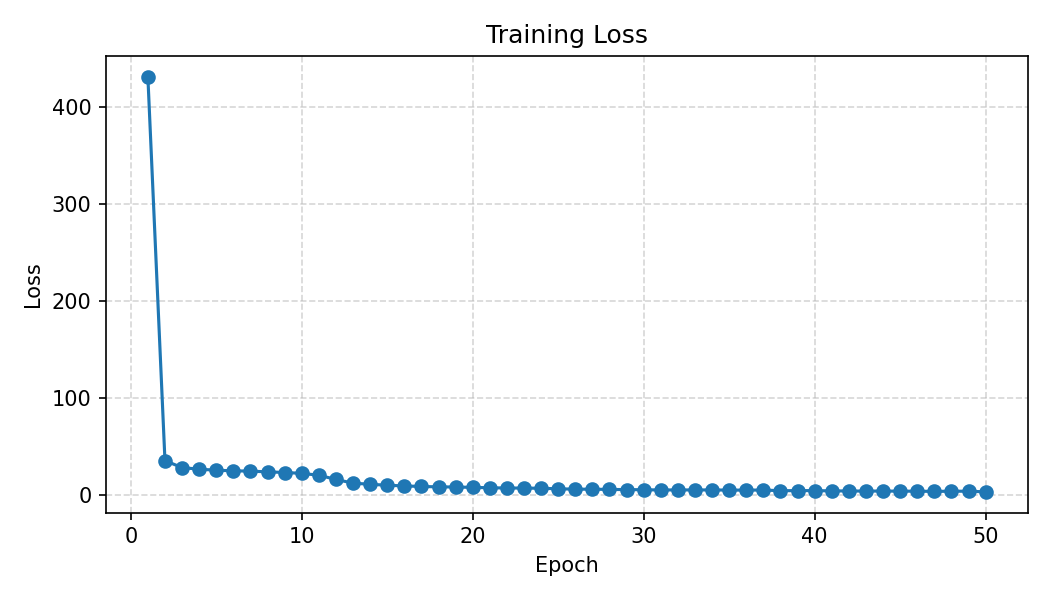

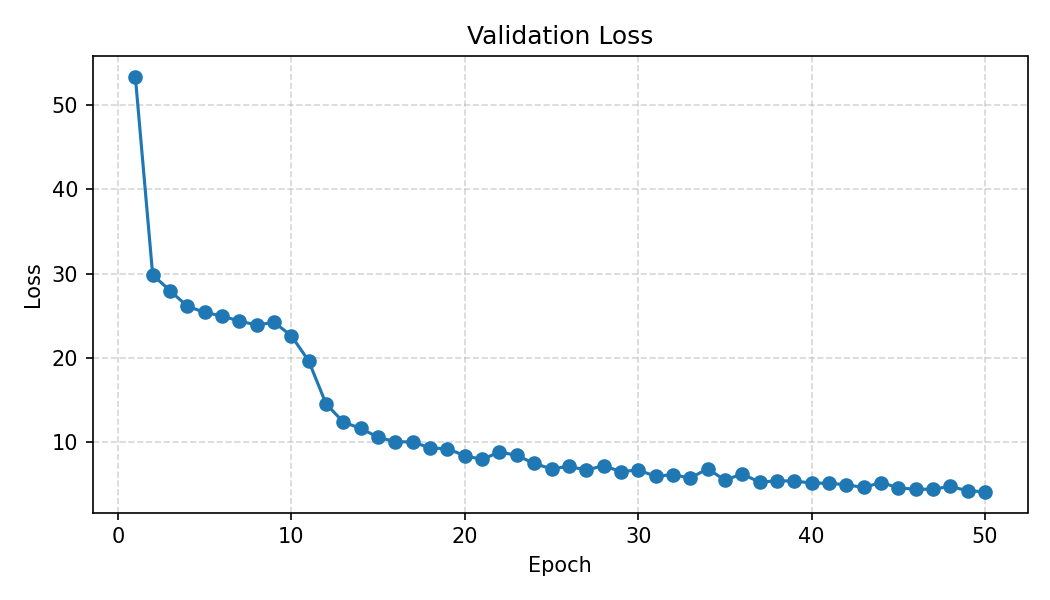

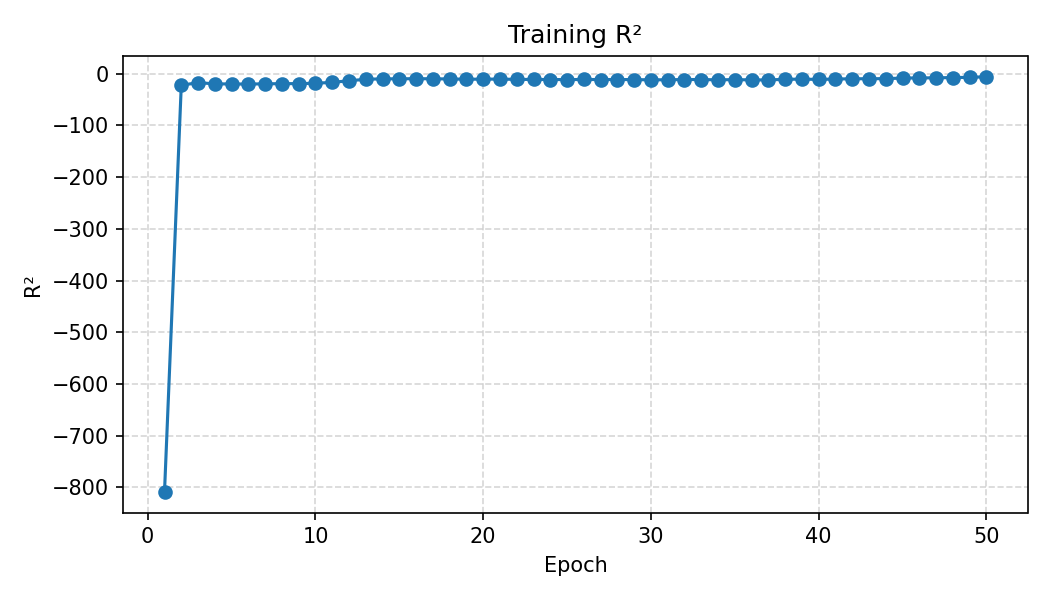

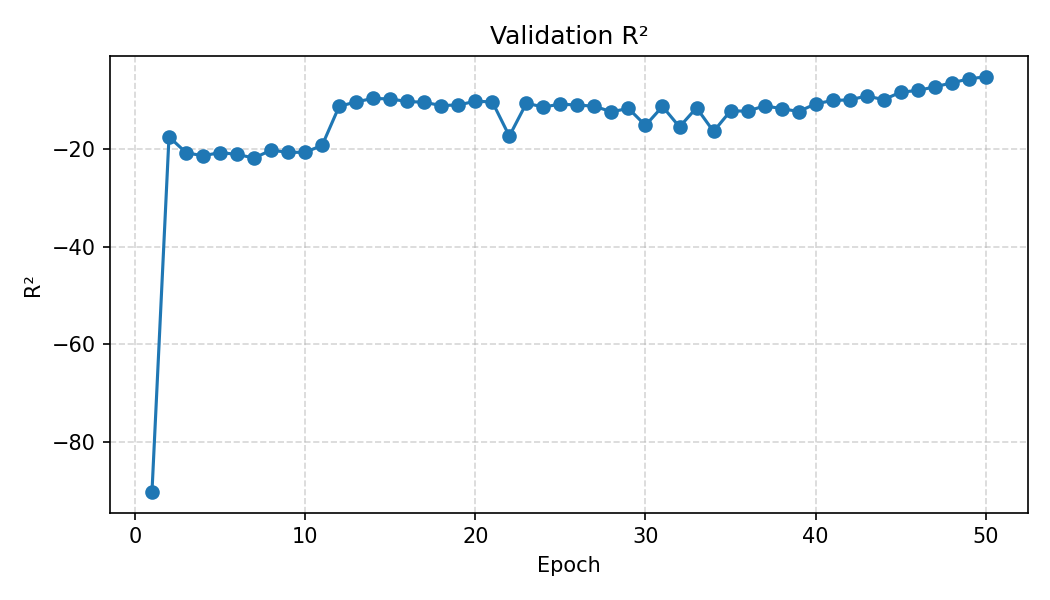

In [6]:
import sys
from pathlib import Path
from subprocess import run
from IPython.display import Image, display

plot_cmd = [
    sys.executable,
    "plot_training_curves.py",
    "--metrics-path", str(Path(METRICS_PATH)),
    "--output-dir", str(Path(PLOTS_DIR)),
    "--dpi", "150",
]
print("Running:", " ".join(plot_cmd))
run(plot_cmd, check=True)

for image_name in [
    "training_loss.png",
    "validation_loss.png",
    "training_r2.png",
    "validation_r2.png",
]:
    image_path = Path(PLOTS_DIR) / image_name
    if image_path.exists():
        display(Image(filename=str(image_path)))
    else:
        print("Missing plot:", image_path)

,epoch,train_loss,train_mae,train_r2,val_loss,val_mae,val_r2
5,6,25.257900,3.759612,-19.960922,24.956560,3.781117,-21.025953
6,7,24.901070,3.729670,-19.360151,24.365322,3.767525,-21.760302
7,8,24.196281,3.686910,-19.169273,23.888155,3.698462,-20.142193
8,9,23.506708,3.640806,-18.980433,24.214447,3.739925,-20.600721
9,10,22.627122,3.570642,-18.366566,22.609608,3.615877,-20.585732


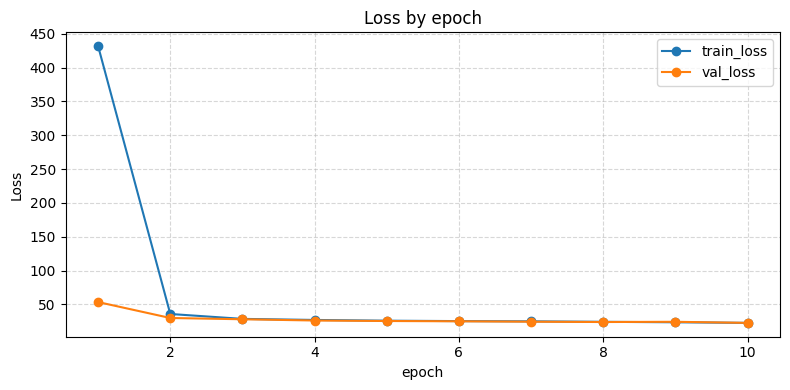

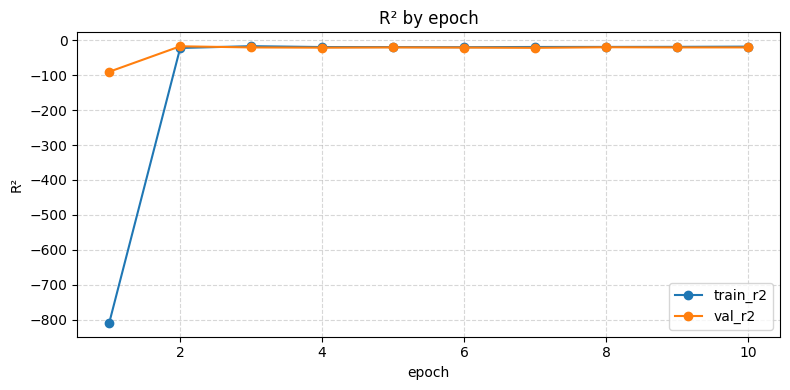

In [8]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

metrics_path = Path("logs/location_training_metrics.csv")
if metrics_path.exists():
    df = pd.read_csv(metrics_path)
    display(df.tail(5))

    fig, ax = plt.subplots(figsize=(8, 4))
    df.plot(x="epoch", y=["train_loss", "val_loss"], ax=ax, marker="o")
    ax.set_title("Loss by epoch")
    ax.set_ylabel("Loss")
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(8, 4))
    df.plot(x="epoch", y=["train_r2", "val_r2"], ax=ax, marker="o")
    ax.set_title("R² by epoch")
    ax.set_ylabel("R²")
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("Metrics CSV not found; run the training cell first.")

## Inference

`infer_location.py` loads the latest checkpoint, runs the CNN on validation samples, and prints target/prediction pairs. Use `--fhe-mode`/`--quantized-module-path` when benchmarking encrypted execution.

In [9]:
import sys
from pathlib import Path
from subprocess import run

infer_cmd = [
    sys.executable,
    "infer_location.py",
    "--dataset-file", str(Path(DATASET_FILE)),
    "--checkpoint-dir", str(Path(CHECKPOINT_PATH).parent),
    "--artifacts-dir", str(Path(STATS_PATH).parent),
    "--max-inference-samples", str(NUM_INFERENCE_SAMPLES),
    "--fhe-mode", FHE_MODE,
    "--device", DEVICE,
    "--seed", str(SEED),
]

print("Running:", " ".join(infer_cmd))
run(infer_cmd, check=True)

Running: /Users/rbkv2/src/csi_positioning/.venv/bin/python infer_location.py --dataset-file dataset/dataset_SNR50_outdoor.mat --checkpoint-dir checkpoints --artifacts-dir artifacts --max-inference-samples 10 --fhe-mode disable --device cpu --seed 42
Loading model with architecture: optimized
Running inference on 10 validation samples...
Sample 66: target=[39.5, 47.5, 22.200000762939453] pred=[38.361148834228516, 47.680152893066406, 22.178422927856445]
  ℓ1 error=0.4469
Sample 594: target=[38.5, 44.0, 22.200000762939453] pred=[38.433292388916016, 47.24335479736328, 21.88922691345215]
  ℓ1 error=1.2069
Sample 68: target=[37.5, 56.5, 21.700000762939453] pred=[36.181087493896484, 55.459144592285156, 22.358964920043945]
  ℓ1 error=1.0062
Sample 503: target=[17.0, 45.0, 22.200000762939453] pred=[20.757844924926758, 51.177982330322266, 22.745107650756836]
  ℓ1 error=3.4936
Sample 337: target=[43.0, 57.0, 21.700000762939453] pred=[39.531959533691406, 52.256675720214844, 22.60642433166504]
  ℓ1

Inference Progress: 100%|██████████| 10/10 [00:00<00:00, 674.44sample/s]


CompletedProcess(args=['/Users/rbkv2/src/csi_positioning/.venv/bin/python', 'infer_location.py', '--dataset-file', 'dataset/dataset_SNR50_outdoor.mat', '--checkpoint-dir', 'checkpoints', '--artifacts-dir', 'artifacts', '--max-inference-samples', '10', '--fhe-mode', 'disable', '--device', 'cpu', '--seed', '42'], returncode=0)

Running: /Users/rbkv2/src/csi_positioning/.venv/bin/python visualize_performance.py --results-csv artifacts/inference_results_optimized.csv --output-dir plots
Saved plots to plots


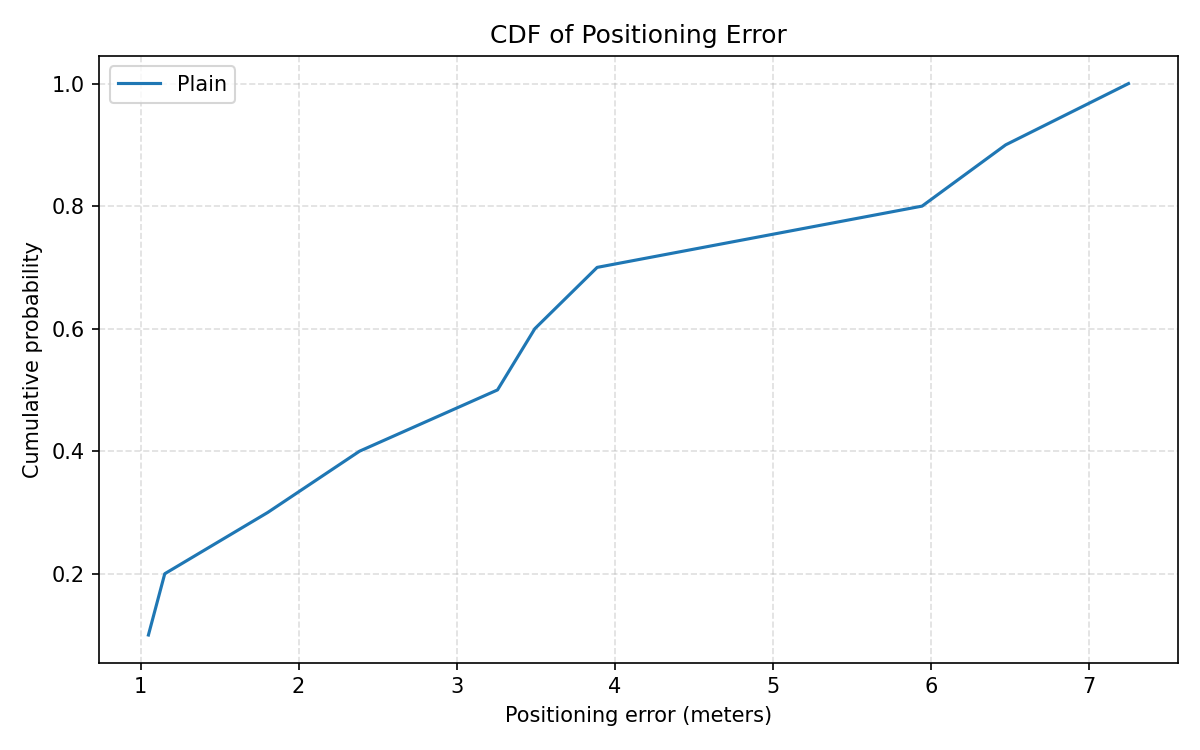

Missing plot: error_vectors_3d.png (Check if FHE inference was run)
Missing plot: xy_projection.png (Check if FHE inference was run)


In [10]:
import sys
from pathlib import Path
from subprocess import run
from IPython.display import Image, display

# Visualize Inference Performance
viz_cmd = [
    sys.executable,
    "visualize_performance.py",
    "--results-csv", str(Path(INFERENCE_RESULTS_PATH)),
    "--output-dir", str(Path(PLOTS_DIR)),
]
print("Running:", " ".join(viz_cmd))
run(viz_cmd, check=True)

# Display Plots
for image_name in [
    "error_cdf.png",
    "error_vectors_3d.png",
    "xy_projection.png",
]:
    image_path = Path(PLOTS_DIR) / image_name
    if image_path.exists():
        display(Image(filename=str(image_path)))
    else:
        print(f"Missing plot: {image_name} (Check if FHE inference was run)")